In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_DIR = './models'
DATA_DIR = './data'
RESULT_DIR = './results'
BATCH_SIZE = 128
FGSM_EPS = 0.03  # Perturbation magnitude (8/255)

CIFAR10_CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(" Libraries imported")
print(f"Device: {DEVICE}")
print(f"FGSM epsilon: {FGSM_EPS}")


 Libraries imported
Device: cpu
FGSM epsilon: 0.03


In [9]:
# ==================== LOAD MODEL ====================

print("Loading trained model...")

model = models.resnet18(num_classes=10)
model.load_state_dict(torch.load('./models/baseline_resnet18_best.pth', map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

print(" Model loaded successfully")

# ==================== LOAD DATA ====================

print("Loading test data...")

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                       (0.2023, 0.1994, 0.2010))
])

test_dataset = datasets.CIFAR10(
    root=DATA_DIR, 
    train=False, 
    download=False,  # Already downloaded
    transform=transform_test
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f" Test data loaded: {len(test_dataset)} samples")
print(f" Batch size: {BATCH_SIZE}")


Loading trained model...
 Model loaded successfully
Loading test data...
 Test data loaded: 10000 samples
 Batch size: 128


In [10]:
# ==================== FGSM ATTACK ====================

def fgsm_attack(model, images, labels, eps=0.03):
    """
    Fast Gradient Sign Method (FGSM) Attack
    
    How it works:
    1. Forward pass to get loss
    2. Backward pass to get gradients
    3. Take sign of gradients (direction to maximize loss)
    4. Add small perturbation in that direction
    5. Result: Image looks same to humans, but fools the model!
    
    Args:
        model: Neural network
        images: Input images
        labels: True labels
        eps: Perturbation magnitude (default: 0.03)
    
    Returns:
        adversarial_images: Attacked images
        perturbations: The noise added
    """
    
    # Images need gradients for attack
    images = images.clone().detach().to(DEVICE)
    labels = labels.to(DEVICE)
    images.requires_grad = True
    
    # Forward pass
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    
    # Backward pass to get gradients
    model.zero_grad()
    loss.backward()
    
    # Get gradient direction (sign)
    data_grad = images.grad.data
    sign_data_grad = data_grad.sign()
    
    # Create adversarial image
    adversarial_images = images + eps * sign_data_grad
    
    # Clamp to valid image range
    adversarial_images = torch.clamp(adversarial_images, 0, 1)
    
    return adversarial_images.detach(), sign_data_grad.detach()


print(" FGSM attack function defined")
print(f"  Attack strength (epsilon): {FGSM_EPS}")
print(f"  Max pixel change: {FGSM_EPS * 255:.1f}/255")


 FGSM attack function defined
  Attack strength (epsilon): 0.03
  Max pixel change: 7.6/255


In [11]:
# ==================== EVALUATE CLEAN ACCURACY ====================

print("\n" + "="*60)
print("EVALUATING CLEAN ACCURACY (No Attack)")
print("="*60 + "\n")

clean_correct = 0
total = 0

model.eval()

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluating clean'):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(images)
        _, predictions = outputs.max(1)
        
        clean_correct += (predictions == labels).sum().item()
        total += labels.size(0)

clean_accuracy = 100 * clean_correct / total

print(f"\n Clean Accuracy: {clean_accuracy:.2f}%")
print(f"  (Model works well on normal images)")



EVALUATING CLEAN ACCURACY (No Attack)



Evaluating clean: 100%|██████████████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.53it/s]


 Clean Accuracy: 81.75%
  (Model works well on normal images)


In [12]:
# ==================== PERFORM FGSM ATTACK ====================

print("\n" + "="*60)
print("PERFORMING FGSM ATTACK")
print("="*60 + "\n")

fgsm_correct = 0
total = 0
attack_samples = None

model.eval()

for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc='FGSM attack')):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    
    # Get clean predictions
    with torch.no_grad():
        outputs_clean = model(images)
        _, pred_clean = outputs_clean.max(1)
    
    # Generate adversarial examples
    adversarial_images, perturbations = fgsm_attack(model, images, labels, eps=FGSM_EPS)
    
    # Get adversarial predictions
    with torch.no_grad():
        outputs_adv = model(adversarial_images)
        _, pred_adv = outputs_adv.max(1)
    
    # Count correct predictions
    fgsm_correct += (pred_adv == labels).sum().item()
    total += labels.size(0)
    
    # Store first batch for visualization
    if batch_idx == 0:
        attack_samples = {
            'clean': images[:8].cpu(),
            'adversarial': adversarial_images[:8].cpu(),
            'perturbations': perturbations[:8].cpu(),
            'labels': labels[:8].cpu(),
            'pred_clean': pred_clean[:8].cpu(),
            'pred_adv': pred_adv[:8].cpu()
        }

fgsm_accuracy = 100 * fgsm_correct / total

print(f"\n{'='*60}")
print("RESULTS")
print(f"{'='*60}")
print(f"Clean Accuracy:       {clean_accuracy:.2f}%")
print(f"FGSM Accuracy:        {fgsm_accuracy:.2f}%")
print(f"Accuracy Drop:        {clean_accuracy - fgsm_accuracy:.2f}%")
print(f"Robustness Ratio:     {fgsm_accuracy/clean_accuracy*100:.1f}%")
print(f"{'='*60}\n")

print(" WOW! The model's accuracy dropped drastically!")
print(f"   With just {FGSM_EPS} perturbation (almost invisible),")
print(f"   accuracy went from {clean_accuracy:.1f}% → {fgsm_accuracy:.1f}%")



PERFORMING FGSM ATTACK



FGSM attack: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [05:02<00:00,  3.83s/it]


RESULTS
Clean Accuracy:       81.75%
FGSM Accuracy:        35.25%
Accuracy Drop:        46.50%
Robustness Ratio:     43.1%

 WOW! The model's accuracy dropped drastically!
   With just 0.03 perturbation (almost invisible),
   accuracy went from 81.8% → 35.2%


Creating visualization...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015294552..4.404196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015294552..4.9139996].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015294552..4.757137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015294552..3.527882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015294552..4.63949].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0015294552..4.6651373].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.

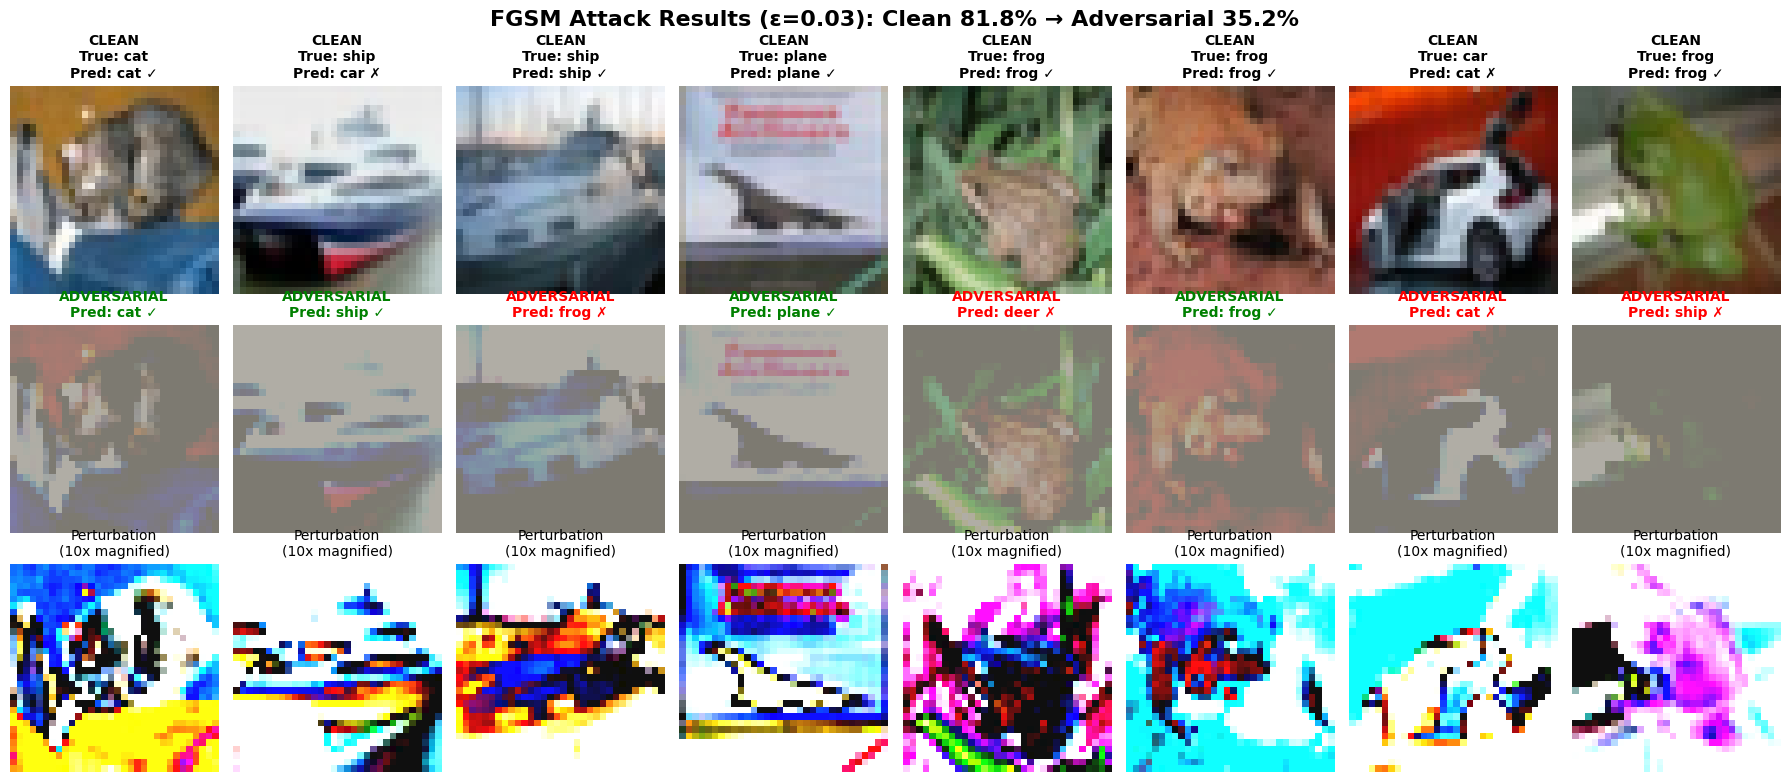

 Visualization saved to: ./results/fgsm_attack_visualization.png

 Notice: Images look IDENTICAL to humans, but model fails!


In [13]:
# ==================== VISUALIZE ATTACK ====================

def denormalize(img):
    """Denormalize CIFAR-10 images for display"""
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + \
          torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    return img.clamp(0, 1)

print("Creating visualization...")

fig, axes = plt.subplots(3, 8, figsize=(18, 8))

for i in range(8):
    # Row 1: Clean images
    clean_img = denormalize(attack_samples['clean'][i])
    axes[0, i].imshow(clean_img.permute(1, 2, 0))
    
    true_label = CIFAR10_CLASSES[attack_samples['labels'][i].item()]
    pred_clean = CIFAR10_CLASSES[attack_samples['pred_clean'][i].item()]
    correct_str = "✓" if attack_samples['pred_clean'][i] == attack_samples['labels'][i] else "✗"
    
    axes[0, i].set_title(f'CLEAN\nTrue: {true_label}\nPred: {pred_clean} {correct_str}', 
                         fontsize=10, fontweight='bold')
    axes[0, i].axis('off')
    
    # Row 2: Adversarial images
    adv_img = denormalize(attack_samples['adversarial'][i])
    axes[1, i].imshow(adv_img.permute(1, 2, 0))
    
    pred_adv = CIFAR10_CLASSES[attack_samples['pred_adv'][i].item()]
    correct_str = "✓" if attack_samples['pred_adv'][i] == attack_samples['labels'][i] else "✗"
    
    # Highlight if attack succeeded (wrong prediction)
    color = 'green' if correct_str == "✓" else 'red'
    axes[1, i].set_title(f'ADVERSARIAL\nPred: {pred_adv} {correct_str}', 
                         fontsize=10, fontweight='bold', color=color)
    axes[1, i].axis('off')
    
    # Row 3: Perturbation (exaggerated for visibility)
    perturbation = (adv_img - clean_img).abs() * 10  # Multiply by 10 to make visible
    axes[2, i].imshow(perturbation.permute(1, 2, 0))
    axes[2, i].set_title('Perturbation\n(10x magnified)', fontsize=10)
    axes[2, i].axis('off')

fig.suptitle(f'FGSM Attack Results (ε={FGSM_EPS}): Clean {clean_accuracy:.1f}% → Adversarial {fgsm_accuracy:.1f}%', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig('./results/fgsm_attack_visualization.png', dpi=200, bbox_inches='tight')
plt.show()

print(" Visualization saved to: ./results/fgsm_attack_visualization.png")
print("\n Notice: Images look IDENTICAL to humans, but model fails!")


In [15]:
# ==================== FINAL ANALYSIS ====================

print("\n" + "="*60)
print("FGSM ATTACK ANALYSIS")
print("="*60)

print(f"\n Attack Configuration:")
print(f"  • Method: FGSM (Fast Gradient Sign Method)")
print(f"  • Epsilon: {FGSM_EPS}")
print(f"  • Max pixel change: {FGSM_EPS*255:.1f}/255 pixels")
print(f"  • Perturbation: IMPERCEPTIBLE to humans")

print(f"\n Results:")
print(f"  • Clean Accuracy:       {clean_accuracy:.2f}%")
print(f"  • Adversarial Accuracy: {fgsm_accuracy:.2f}%")
print(f"  • Accuracy Drop:        {clean_accuracy - fgsm_accuracy:.2f}%")
print(f"  • Attack Success Rate:  {100 - fgsm_accuracy:.2f}%")

print(f"\n Key Insights:")
print(f"  1. The model is HIGHLY vulnerable to adversarial attacks")
print(f"  2. A tiny perturbation ({FGSM_EPS}) causes massive failure")
print(f"  3. Perturbations are invisible to human eye")
print(f"  4. This demonstrates the need for robust training!")

print(f"\n What This Means:")
print(f"  • Deep learning models are NOT robust by default")
print(f"  • Adversarial training is necessary for real-world deployment")
print(f"  • This project will improve robustness!")

print("\n" + "="*60)

# Save results to file
with open('./results/fgsm_results.txt', 'w') as f:
    f.write("FGSM Attack Results\n")
    f.write("="*60 + "\n")
    f.write(f"Attack: FGSM\n")
    f.write(f"Epsilon: {FGSM_EPS}\n")
    f.write(f"Clean Accuracy: {clean_accuracy:.2f}%\n")
    f.write(f"FGSM Accuracy: {fgsm_accuracy:.2f}%\n")
    f.write(f"Accuracy Drop: {clean_accuracy - fgsm_accuracy:.2f}%\n")
    f.write(f"Attack Success Rate: {100 - fgsm_accuracy:.2f}%\n")

print("\n Results saved to: ./results/fgsm_results.txt")




FGSM ATTACK ANALYSIS

 Attack Configuration:
  • Method: FGSM (Fast Gradient Sign Method)
  • Epsilon: 0.03
  • Max pixel change: 7.6/255 pixels
  • Perturbation: IMPERCEPTIBLE to humans

 Results:
  • Clean Accuracy:       81.75%
  • Adversarial Accuracy: 35.25%
  • Accuracy Drop:        46.50%
  • Attack Success Rate:  64.75%

 Key Insights:
  1. The model is HIGHLY vulnerable to adversarial attacks
  2. A tiny perturbation (0.03) causes massive failure
  3. Perturbations are invisible to human eye
  4. This demonstrates the need for robust training!

 What This Means:
  • Deep learning models are NOT robust by default
  • Adversarial training is necessary for real-world deployment
  • This project will improve robustness!


 Results saved to: ./results/fgsm_results.txt
